In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba

from seaborn import kdeplot
from scipy.stats import norm

In [128]:
means_before = np.load('UK_before_medians.npy')
means_after  = np.load('UK_after_medians.npy')

In [47]:
param_names = [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$',
               r'$\Delta t_1$', r'$\Delta t_2$', r'$\Delta t_3$', r'$\Delta t_4$',
               r'$\lambda_0$', r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$', r'$\lambda_4$', 
               r'$\mu$', r'$f_I$', r'$\phi_I$',  r'$f_R$', r'$\phi_R$',  
               r'$f_D$', r'$\phi_D$',
               r'$D_I$', r'$D_R$', r'$D_D$', r'$E_0$', r'$\sigma_I$', r'$\sigma_R$', r'$\sigma_D$', 
               r'$\alpha$', r'$\beta$', r'$\gamma$',
               r'$\eta$', r'$\theta$', r'$\delta$', r'$d$']

In [48]:
relevant_params = [r'$E_0$', r'$\beta$', r'$\gamma$',
                   r'$\eta$',r'$\mu$',r'$\theta$',
                   r'$d$',r'$\alpha$',r'$\delta$']

In [49]:
numba.jit()
def dectection_rate(n):
    return np.random.normal(0, 1, (1,n))

numba.jit()
def moderate_recovery(n):
    return np.random.normal(9.5, 2.5/2, (1,n))

numba.jit()
def severe_recovery(n):
    recovery = np.random.normal(14, 7/2, (1,n))
    recovery[np.where(recovery < 7)] = 7
    return recovery

numba.jit()
def estimate_recovery(I):
    
    # Split the infections into moderate, severe
    m, s, _ = np.round(np.array([0.804, 0.176,0.018]) * I).astype(int)
    
    recovery = dectection_rate(m + s)
    recovery = np.round(recovery + 
                        np.hstack((moderate_recovery(m), severe_recovery(s)))).astype(int)
    
    return recovery

def approx_recoveries(infections):
    daily_recoveries = np.zeros(infections.shape[0])
    for day, daily_infections in enumerate(infections):
        days_till_recovery, recoveries = np.unique(estimate_recovery(daily_infections), 
                                                   return_counts = True)
        day_of_recovery = day + days_till_recovery
        try:
            daily_recoveries[day_of_recovery] = daily_recoveries[day_of_recovery] + recoveries
        except:
            pass
    
    return daily_recoveries

def split(df, start:any, end:any, column_name:str):
    
    start_row_index = df.index[df.loc[:, column_name] == start][0]
    end_row_index   = df.index[df.loc[:, column_name] == end][0]
    return df.iloc[end_row_index:start_row_index, :]

def Z_test(X, Y):
     
    assert X.shape[0] == Y.shape[0]
    
    X_mean = np.mean(X,0)
    Y_mean = np.mean(Y,0)
    
    X_std = np.var(X,0)
    Y_std = np.var(Y,0) 
    n = X.shape[0]
    
    test_statistic = (X_mean - Y_mean)/(np.sqrt( (X_std/n) + (Y_std/n)))
    probability    = 1 - norm.cdf(np.abs(test_statistic))
    return test_statistic, probability

In [52]:
p = Z_test(means_before, means_after)[1]
for i, param in enumerate(param_names):
    
    if not param in relevant_params:
        continue
        
    print(p[i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


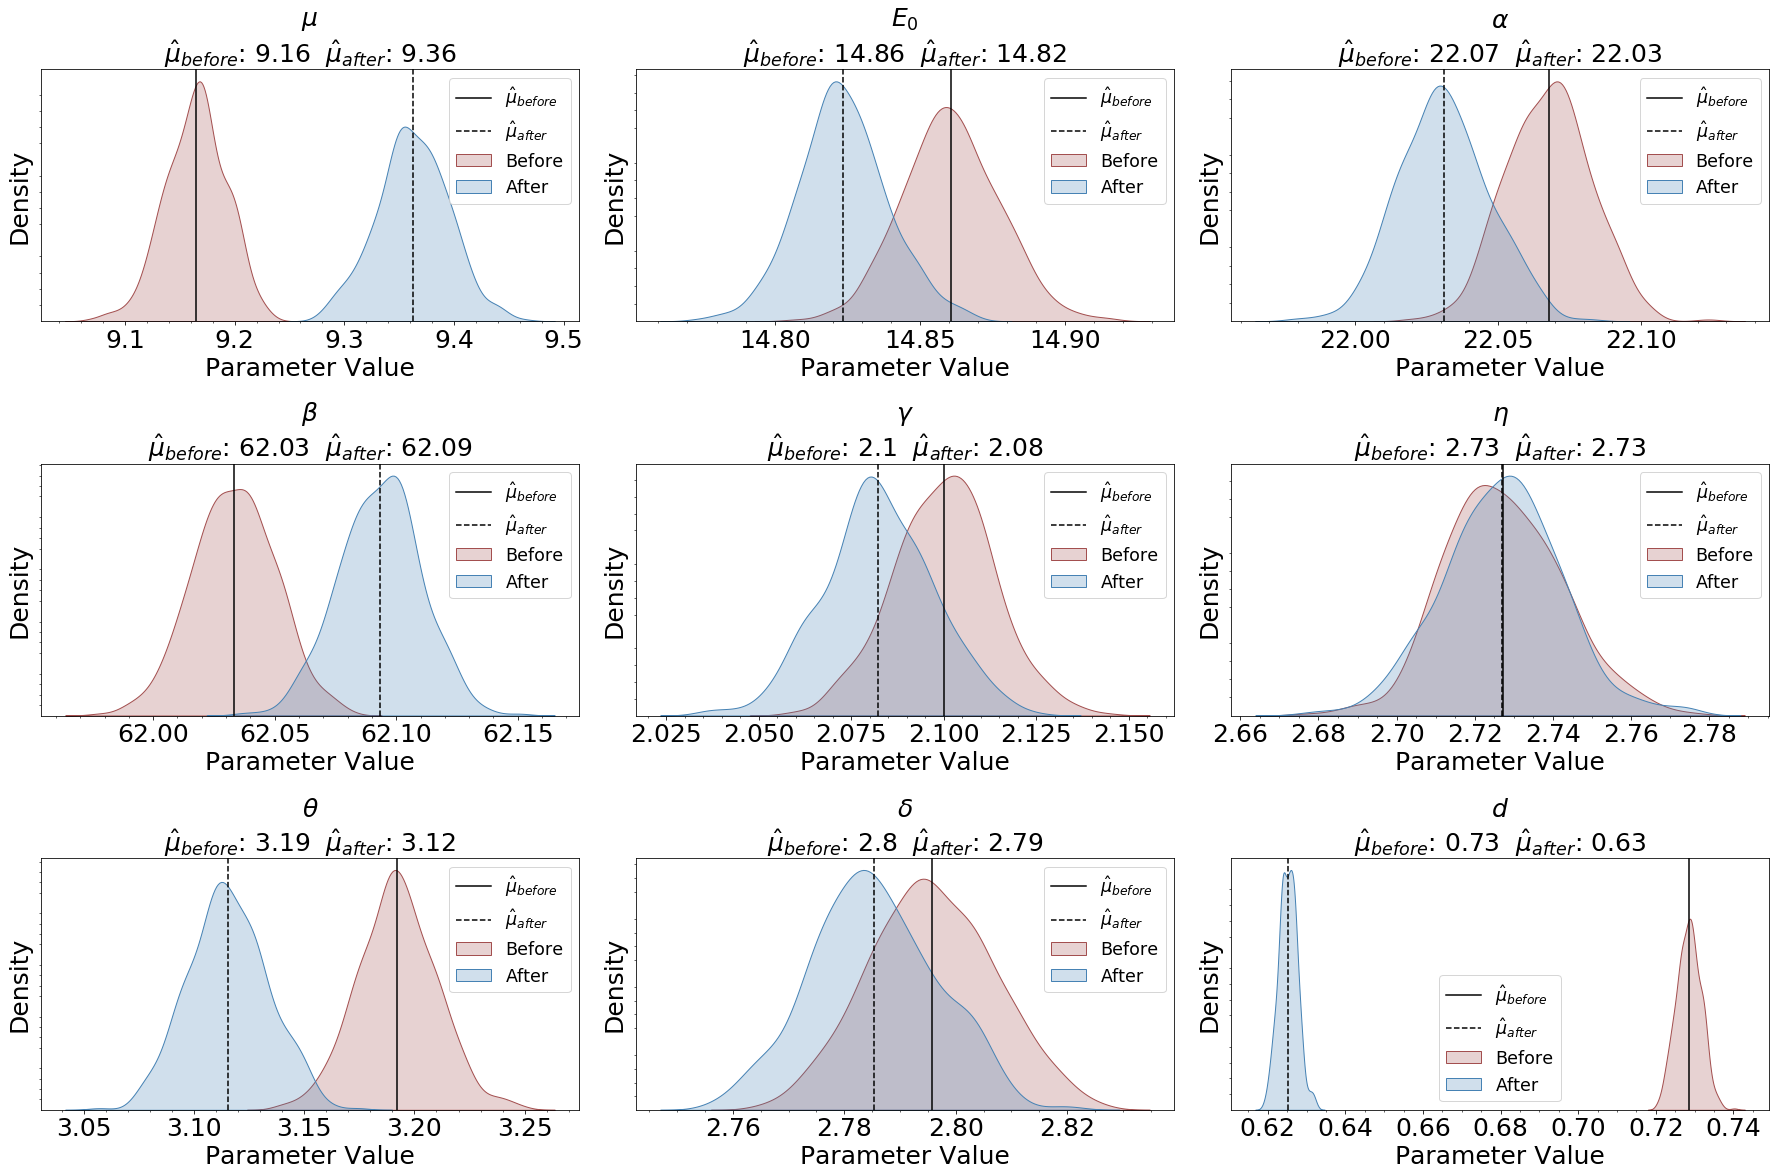

In [129]:
plt.figure(figsize = (25, 25 *  (4/6)))
plt.style.use('latex_document.mplstyle')
plt.rc('font', size=17.5)
plt.rc('axes', titlesize=25) #fontsize of the title
plt.rc('axes', labelsize=25) #fontsize of the x and y labels
plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
plt.rc('ytick', labelsize=25) #fontsize of the y tick labels
    
i = 0
for param in param_names:
    
    if not param in relevant_params:
        continue
    
    plt.subplot(3, 3, i + 1)
    plt.rc('font', size=17.5)
    plt.rc('axes', titlesize=25) #fontsize of the title
    plt.rc('axes', labelsize=25) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=25) #fontsize of the y tick labels
    
    mean_before = r'$\hat{\mu}_{before}$' + ': {}'.format(np.round(np.mean(means_before, 0)[i], 2))
    mean_after  = r'$\hat{\mu}_{after}$'  + ': {}'.format(np.round(np.mean(means_after, 0)[i], 2))
    
    plt.title(param + '\n' + mean_before + '  ' + mean_after)
    kdeplot(means_before[:,i], label = 'Before', color='#a34f4f', fill = True)
    kdeplot(means_after[:,i],  label = 'After',  color='steelblue', fill = True)
    
    plt.axvline(np.mean(means_before, 0)[i], ls = '-',  color = 'black',
                label = r'$\hat{\mu}_{before}$')
    plt.axvline(np.mean(means_after, 0)[i], ls = '--', color = 'black',
                label = r'$\hat{\mu}_{after}$')
    
    plt.tick_params(left=False, bottom=True,  labelleft=False, labelbottom = True)
    plt.ylabel('Density')
    plt.xlabel('Parameter Value')
    
    plt.legend()
    i += 1
    
plt.tight_layout()
plt.savefig('figures/ParameterChangesUK.pdf')
plt.show()

### Plot Infections/Deaths in London
---

In [68]:
#start = '2021-05-01'
#end   = '2021-09-01'
start = '2021-06-20'
end   = '2021-08-01'
event = '2021-07-11'

df_london = pd.read_csv('data/covid19-London.csv')

london_cases  = split(df_london, start, end, 'date').loc[:,'newCasesByPublishDate'].to_numpy()[::-1]
london_deaths = split(df_london, start, end, 'date').loc[:,'newDeaths28DaysByDeathDate'].to_numpy()[::-1]

cases = df_london.loc[:,'newCasesByPublishDate'].to_numpy()
cases[np.isnan(cases)] = 0
london_recov = approx_recoveries(cases)

event_index = df_london.index[df_london.loc[:, 'date'] == event][0]
start_row_index = df_london.index[df_london.loc[:, 'date'] == start][0]
end_row_index   = df_london.index[df_london.loc[:, 'date'] == end][0]
london_recov    = london_recov[end_row_index:start_row_index][::-1]

In [69]:
start = '2021-06-20'
end   = '2021-08-01'

gb_cases_df  = pd.read_csv('data/covid19-greatbritain_cases.csv')
gb_deaths_df = pd.read_csv('data/covid19-greatbritain_deaths.csv')
gb_cases  = split(gb_cases_df, start, end, 'date')
gb_deaths = split(gb_deaths_df, start, end, 'date')

gb_cases  = gb_cases.loc[:,'newCasesBySpecimenDate'].to_numpy()[::-1]
gb_deaths = gb_deaths.loc[:,'newDeaths28DaysByDeathDate'].to_numpy()[::-1]

start_row_index = gb_cases_df.index[gb_cases_df.loc[:, 'date'] == start][0]
end_row_index   = gb_cases_df.index[gb_cases_df.loc[:, 'date'] == end][0]
gb_recov  = approx_recoveries(gb_cases_df.loc[:,'newCasesBySpecimenDate'].to_numpy())

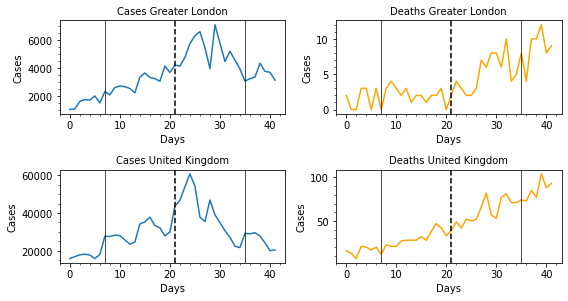

In [85]:
plt.figure(figsize = (8,16/2))
plt.subplot(4,2,1)
plt.title('Cases Greater London')
plt.plot(london_cases,  label = 'New Infections')
plt.axvline(7, ls = '-',color = 'black', lw = 0.7)
plt.axvline(21, ls = '--',color = 'black')
plt.axvline(35, ls = '-',color = 'black', lw = 0.7)
plt.xlabel('Days')
plt.ylabel('Cases')

plt.subplot(4,2,2)
plt.title('Deaths Greater London')
plt.plot(london_deaths, label = 'Deaths', color = 'orange')
plt.axvline(7, ls = '-',color = 'black', lw = 0.7)
plt.axvline(21, ls = '--',color = 'black')
plt.axvline(35, ls = '-',color = 'black', lw = 0.7)
plt.xlabel('Days')
plt.ylabel('Cases')

plt.subplot(4,2,3)
plt.title('Cases United Kingdom')
plt.plot(gb_cases,  label = 'New Infections')
plt.axvline(7, ls = '-',color = 'black', lw = 0.7)
plt.axvline(21, ls = '--',color = 'black')
plt.axvline(35, ls = '-',color = 'black', lw = 0.7)
plt.xlabel('Days')
plt.ylabel('Cases')


plt.subplot(4,2,4)
plt.title('Deaths United Kingdom')
plt.plot(gb_deaths, label = 'Deaths', color = 'orange')
plt.axvline(7, ls = '-',color = 'black', lw = 0.7)
plt.axvline(21, ls = '--',color = 'black')
plt.axvline(35, ls = '-',color = 'black', lw = 0.7)
plt.xlabel('Days')
plt.ylabel('Cases')

plt.savefig('figures/casesUK.png')
plt.show()

### Plot Infections/Deaths in Tokyo
---

In [5]:
start = '2021/7/11'
end   = '2021/8/22'
#start = '2021/8/1'
#end   = '2021/8/15'

japan_all_cases_df = pd.read_csv('data/covid19-Japan_confirmed_cases_daily.csv')
japan_all_cumulative_deaths_df = pd.read_csv('data/covid19-Japan_deaths_cumulative_daily.csv')

tokyo_cases_df = japan_all_cases_df[japan_all_cases_df['Prefecture'] == 'Tokyo'].reset_index()
japan_cases_df = japan_all_cases_df[japan_all_cases_df['Prefecture'] == 'ALL'].reset_index()

# Estimate Recoviers and add to the respective data frame.
tokyo_recov = approx_recoveries(tokyo_cases_df['Newly confirmed cases'].to_numpy())
japan_recov = approx_recoveries(japan_cases_df['Newly confirmed cases'].to_numpy())

tokyo_cases_df['Recoveries'] = tokyo_recov
japan_cases_df['Recoveries'] = japan_recov

# Obtain the 
tokyo_deaths_df = japan_all_cumulative_deaths_df[
                     japan_all_cumulative_deaths_df['Prefecture'] == 'Tokyo'].reset_index()
japan_deaths_df = japan_all_cumulative_deaths_df[
                     japan_all_cumulative_deaths_df['Prefecture'] == 'ALL'].reset_index()

tokyo_deaths_df['Deaths'] = np.hstack((np.array(1),
                                       np.diff(tokyo_deaths_df['Deaths(Cumulative)'].to_numpy())))
japan_deaths_df['Deaths'] = np.hstack((np.array(1),
                                       np.diff(japan_deaths_df['Deaths(Cumulative)'].to_numpy())))

tokyo_recov = approx_recoveries(tokyo_cases_df['Newly confirmed cases'].to_numpy())
japam_recov = approx_recoveries(japan_cases_df['Newly confirmed cases'].to_numpy())

tokyo_cases_df = split(tokyo_cases_df, end, start, 'Date')
japan_cases_df = split(japan_cases_df, end, start, 'Date')

tokyo_deaths_df = split(tokyo_deaths_df, end, start, 'Date')
japan_deaths_df = split(japan_deaths_df, end, start, 'Date')

tokyo_cases  = tokyo_cases_df['Newly confirmed cases'].to_numpy()
japan_cases  = japan_cases_df['Newly confirmed cases'].to_numpy()

tokyo_recov  = tokyo_cases_df['Recoveries'].to_numpy()
japan_recov  = japan_cases_df['Recoveries'].to_numpy()

tokyo_deaths = tokyo_deaths_df['Deaths'].to_numpy()
japan_deaths = japan_deaths_df['Deaths'].to_numpy()

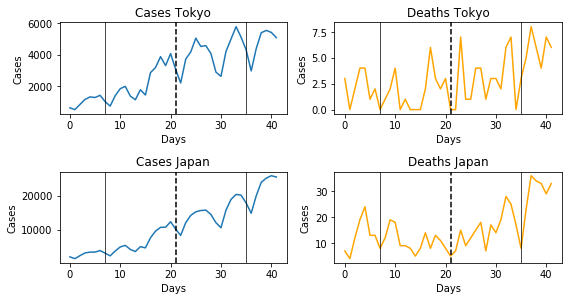

In [10]:
plt.figure(figsize = (8,16/2))
plt.subplot(4,2,1)
plt.title('Cases Tokyo')
plt.plot(tokyo_cases,  label = 'New Infections')
plt.axvline(7, ls = '-',color = 'black', lw = 0.7)
plt.axvline(21, ls = '--',color = 'black')
plt.axvline(35, ls = '-',color = 'black', lw = 0.7)
plt.xlabel('Days')
plt.ylabel('Cases')

plt.subplot(4,2,2)
plt.title('Deaths Tokyo')
plt.plot(tokyo_deaths, label = 'Deaths', color = 'orange')
plt.axvline(7, ls = '-',color = 'black', lw = 0.7)
plt.axvline(21, ls = '--',color = 'black')
plt.axvline(35, ls = '-',color = 'black', lw = 0.7)
plt.xlabel('Days')
plt.ylabel('Cases')

plt.subplot(4,2,3)
plt.title('Cases Japan')
plt.plot(japan_cases,  label = 'New Infections')
plt.axvline(7, ls = '-',color = 'black', lw = 0.7)
plt.axvline(21, ls = '--',color = 'black')
plt.axvline(35, ls = '-',color = 'black', lw = 0.7)
plt.xlabel('Days')
plt.ylabel('Cases')


plt.subplot(4,2,4)
plt.title('Deaths Japan')
plt.plot(japan_deaths, label = 'Deaths', color = 'orange')
plt.axvline(7, ls = '-',color = 'black', lw = 0.7)
plt.axvline(21, ls = '--',color = 'black')
plt.axvline(35, ls = '-',color = 'black', lw = 0.7)
plt.xlabel('Days')
plt.ylabel('Cases')

plt.tight_layout()
plt.savefig('figures/casesJapan.pdf')
plt.show()